In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from scipy.stats import linregress
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp
from scipy.stats import rankdata

import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [39]:
PROTEINS = [
    "5P",
    "NSP1",
    "NSP2",
    "NSP3",
    "NSP4",
    "NSP5",
    "NSP6",
    "NSP7",
    "NSP8",
    "NSP9",
    "NSP10",
    "NSP11",
    "NSP12",
    "NSP13",
    "NSP14",
    "NSP15",
    "NSP16",
    "Spike",
    "NS3",
    "E",
    "M",
    "NS6",
    "NS7a",
    "NS7b",
    "NS8",
    "N",
    "NS9b",
    "NS9c",
    "3P",
    "RNA"
]

ANNOTATION = {
    "5P": "1-265",
    "NSP1": "266-805",
    "NSP2": "806-2719",
    "NSP3": "2720-8554",
    "NSP4": "8555-10054",
    "NSP5": "10055-10972",
    "NSP6": "10973-11842",
    "NSP7": "11843-12091",
    "NSP8": "12092-12685",
    "NSP9": "12686-13024",
    "NSP10": "13025-13441",
    "NSP11": "13442-13480",
    # "NSP12": "13442-13468",
    "NSP12": "13468-16236",
    "NSP13": "16237-18039",
    "NSP14": "18040-19620",
    "NSP15": "19621-20658",
    "NSP16": "20659-21552",
    "Spike": "21563-25384",
    "NS3": "25393-26220",
    "E": "26245-26472",
    "M": "26523-27191",
    "NS6": "27202-27387",
    "NS7a": "27394-27759",
    "NS7b": "27756-27887",
    "NS8": "27894-28259",
    "N": "28274-29533",
    "NS9b": "28284-28577",
    "NS9c": "28734-28955",
    "3P": "29534-30331"
}

In [40]:
def read_fasta(path):
    result = ""
    description = ""

    ff = open(path, "r")

    line = next(ff, None)
    while line:
        line = line.rstrip("\n")
        if not line:
            line = next(ff, None)
            continue

        if line.startswith(">"):
            if result:
                yield description, result
            description = line.lstrip(">")
            result = ""
        else:
            result += line

        line = next(ff, None)

    yield description, result
    ff.close()
    
def percent(seq, chr="N"):
    count = 0
    for char in seq:
        if char == chr:
            count += 1
    return count / len(seq)

def region_count(reg, start=None, end=None):
    reg = reg.lstrip("[").rstrip("]").split(", ")
    if not (start is None) and not (end is None):
        reg = [s for s in reg if s and (start <= int(s) <= end)]
    else:
        reg = [s for s in reg if s]
    return len(reg)

In [41]:
# meta preparation

In [42]:
meta_df = pd.read_csv(
    "../../gisaid/russia_mos_meta.csv",
    sep=",", index_col=0)

rna_df = pd.DataFrame(columns=["strain", "length", "polyA", "percN"])
tqdrator = tqdm.tqdm(read_fasta("../../gisaid/russia_mos.fasta"), total=2520)
for covid, rna in tqdrator:
    length = len(rna)
    perc = percent(rna, "N")
    poly = len(rna) - len(rna.rstrip("A"))
    append_df = pd.DataFrame(
        columns=rna_df.columns.to_list(),
        data=[[
            covid,
            length,
            poly,
            perc
        ]]
    )
    rna_df = pd.concat([rna_df, append_df], ignore_index=True)

rna_df.index = rna_df["strain"]
rna_df = rna_df.drop(columns=["strain"])
meta_df = meta_df.join(rna_df, how="inner")

meta_df["date"] = meta_df.index.str.split("|").str[1]
meta_df["date"] = pd.to_datetime(meta_df["date"], format="%Y-%m-%d")
meta_df = meta_df.sort_values(by=["date"])

meta_df["date"] = meta_df.index.str.split("|").str[1]
meta_df["date"] = pd.to_datetime(meta_df["date"], format="%Y-%m-%d")
meta_df = meta_df.sort_values(by=["date"])

meta_df = meta_df.loc[meta_df["date"].astype("str").apply(lambda dt: len(dt.split("-"))) == 3]
meta_df["year"] = meta_df["date"].astype("str").str.split("-").str[0].astype("int")
meta_df["month"] = meta_df["date"].astype("str").str.split("-").str[1].astype("int")
meta_df["day"] = meta_df["date"].astype("str").str.split("-").str[2].astype("int")
meta_df["days"] = meta_df["day"] + meta_df["month"] * 30 + meta_df["year"] * 365
start = int(meta_df.iloc[0]["days"])
meta_df["days"] -= start
meta_df = meta_df.drop(columns=["year", "month", "day"])

100%|██████████| 2520/2520 [00:11<00:00, 213.91it/s]


In [43]:
# higly expressed miRNAs

In [44]:
miRNA_df = pd.read_csv("../../miRNA/expressed_LUAD.csv", sep=",")
miRNA_df.index = miRNA_df["MIMAT"]

TOTAL_EXPRESSION = miRNA_df["CPM"].sum()
MIMATS = miRNA_df["MIMAT"].to_list()

In [45]:
# Moscow VOC's description

In [46]:
df = meta_df.loc[
    (~meta_df["scorpio_call"].isna()) & \
    # No dominance
    (meta_df["percN"] > 0.) & \
    # Equal distributions
    # (meta_df["percN"] > 0.0005) & \
    (meta_df["percN"] < 0.001) & \
    (meta_df["length"] > 29000)
]

STRAINS = []
df["strain"] = df.index
STRAINS = df["strain"].to_list()

<ipython-input-46-bd003242fe6c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["strain"] = df.index


In [57]:
STRAINS[:1]

['hCoV-19/Russia/MOS-RII-MH16110S/2021|2021-03-19|2021-05-06']

In [60]:
output = open("russia_mos_vocs.fasta", "w")
for description, seq in read_fasta("../../gisaid/russia_mos.fasta"):
    if description.lstrip(">") in STRAINS:
        output.write(">" + description.lstrip("\n") + "\n")
        output.write(seq + "\n")

In [47]:
print(meta_df.iloc[0]["date"])
print(meta_df.iloc[-1]["date"])
print(len(meta_df))

2020-03-11 00:00:00
2022-08-22 00:00:00
2520


In [48]:
print(meta_df.loc[STRAINS].iloc[0]["date"])
print(meta_df.loc[STRAINS].iloc[-1]["date"])

2021-03-19 00:00:00
2022-08-08 00:00:00


In [49]:
meta_df = meta_df.loc[STRAINS]

In [50]:
print(meta_df["scorpio_call"].value_counts().sum())
meta_df["scorpio_call"].value_counts()

273


Omicron (BA.5-like)              202
Delta (B.1.617.2-like)            52
Alpha (B.1.1.7-like)               5
Probable Omicron (Unassigned)      5
Omicron (Unassigned)               4
Omicron (BA.2-like)                3
Omicron (BA.1-like)                1
Omicron (BA.4-like)                1
Name: scorpio_call, dtype: int64

In [51]:
meta_df.loc[:, "group"] = "first"
# meta_df.loc[meta_df["days"] > 650, "group"] = "second"
meta_df.loc[meta_df["scorpio_call"].str.contains("micron"), "group"] = "second"

In [52]:
print(meta_df.loc[meta_df.index.isin(STRAINS) & \
    (meta_df["group"] == "first")
    ][["scorpio_call"]].value_counts().sum())

meta_df.loc[
    meta_df.index.isin(STRAINS) & \
    (meta_df["group"] == "first")
][["scorpio_call"]].value_counts()

57


scorpio_call          
Delta (B.1.617.2-like)    52
Alpha (B.1.1.7-like)       5
dtype: int64

In [53]:
print(meta_df.loc[meta_df.index.isin(STRAINS) & \
    (meta_df["group"] == "second")
    ][["scorpio_call"]].value_counts().sum())

meta_df.loc[
    meta_df.index.isin(STRAINS) & \
    (meta_df["group"] == "second")
][["scorpio_call"]].value_counts()

216


scorpio_call                 
Omicron (BA.5-like)              202
Probable Omicron (Unassigned)      5
Omicron (Unassigned)               4
Omicron (BA.2-like)                3
Omicron (BA.1-like)                1
Omicron (BA.4-like)                1
dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


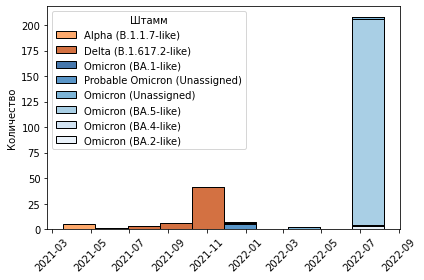

In [54]:
plot_df = meta_df.loc[STRAINS].copy()

plot_df = plot_df.rename(columns={
    "scorpio_call": "Штамм",
    "date": "Дата"
})

top = mpl.colormaps['Blues_r']
bottom = mpl.colormaps['Oranges']
colors = np.vstack((
    bottom(np.linspace(0.5, 0.8, 2)),
    top(np.linspace(0.1, 0.9, 6)),
))
cmap = ListedColormap(colors, name='OrangeBlue')

sns.histplot(
    x="Дата",
    hue="Штамм",
    multiple="stack",
    data=plot_df,
    bins=10,
    palette=cmap.colors
)
plt.ylabel("Количество")
plt.xlabel("")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../../pictures/moscow-strains.png", dpi=500)

MannwhitneyuResult(statistic=6506.0, pvalue=0.5086027689752501)
0.00040127331393596414 0.000339403750266428


<AxesSubplot:xlabel='percN', ylabel='Probability'>

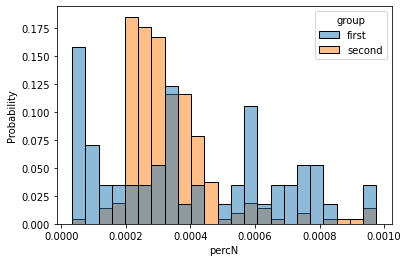

In [55]:
print(mannwhitneyu(
    meta_df.loc[meta_df["group"] == "first"]["percN"],
    meta_df.loc[meta_df["group"] == "second"]["percN"]
))
print(
    meta_df.loc[meta_df["group"] == "first"]["percN"].mean(),
    meta_df.loc[meta_df["group"] == "second"]["percN"].mean()
)
# sns.scatterplot(x="length", y="percN", hue="group", alpha=0.5, data=meta_df)
sns.histplot(
    x="percN",
    hue="group",
    alpha=0.5,
    data=meta_df,
    stat="probability",
    common_norm=False,
)

In [19]:
# region count df

In [20]:
count_df = None
for protein in PROTEINS:
    if protein != "RNA":
        df = pd.read_csv(f"../../results/russia_mos_LUAD_{protein}/seed.csv", sep=";", index_col=0)
    else:
        df = pd.read_csv(f"../../results/russia_mos_LUAD/seed.csv", sep=";", index_col=0)
    
    df.index = df.index.str.lstrip(">")
    df = df.loc[STRAINS][MIMATS]
    
    df["strain"] = df.index
    df["region"] = [protein] * len(df)
    
    if count_df is None:
        count_df = df
    else:
        count_df = pd.concat([count_df, df], ignore_index=True)

for mimat in MIMATS:
    count_df[mimat] = count_df[mimat].apply(lambda x: region_count(x))

count_df.loc[:, "count"] = 0
count_df.loc[:, "weighted count"] = 0
for mimat in tqdm.tqdm(MIMATS):
    expression = (miRNA_df.loc[mimat, "CPM"] / TOTAL_EXPRESSION)
    count_df["count"] += count_df[mimat]
    count_df["weighted count"] += count_df[mimat] * expression

100%|██████████| 32/32 [00:00<00:00, 591.59it/s]


In [21]:
wcount_df = pd.read_csv("../../results/wuhan_LUAD/seed.csv", sep=";", index_col=0)

for mimat in MIMATS:
    wcount_df[mimat] = wcount_df[mimat].apply(lambda x: region_count(x))
    
wcount_df.loc[:, "count"] = 0
wcount_df.loc[:, "weighted count"] = 0
for mimat in tqdm.tqdm(MIMATS):
    expression = (miRNA_df.loc[mimat, "CPM"] / TOTAL_EXPRESSION)
    wcount_df["count"] += wcount_df[mimat]
    wcount_df["weighted count"] += wcount_df[mimat] * expression

100%|██████████| 32/32 [00:00<00:00, 720.79it/s]


In [22]:
# average count of binding regions

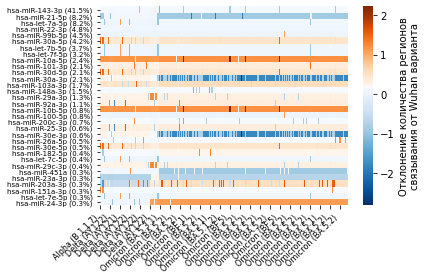

In [23]:
plot_df = count_df.loc[count_df["region"] == "RNA"].copy()

plot_df.index = plot_df["strain"]
plot_df = plot_df[MIMATS]
plot_df = plot_df.join(meta_df[["scorpio_call", "lineage", "length"]], how="left")

for mimat in MIMATS:
    plot_df[mimat] = np.array(plot_df[mimat], dtype=np.float64) * \
        (30331 / np.array(plot_df["length"], dtype=np.float64)) - \
        np.array(wcount_df[mimat], dtype=np.float64)

plot_df["strain"] = plot_df["scorpio_call"].str.split("(").str[0] + "(" + \
    plot_df["lineage"] + ")"
plot_df.index = plot_df["strain"]
plot_df = plot_df[MIMATS]

plot_df = plot_df.transpose()

miRNA_df.index = miRNA_df["MIMAT"]
plot_df = plot_df.join(miRNA_df[["miRNA", "CPM"]], how="left").sort_values(by="CPM", ascending=False)
plot_df.index = plot_df["miRNA"]
plot_df = plot_df.drop(columns=["miRNA", "CPM"])

plot_df["index"] = plot_df.index
miRNA_df.index = miRNA_df["miRNA"]
plot_df["index"] = plot_df["index"].apply(lambda x: f"{x} ({miRNA_df.loc[x]['CPM'] / miRNA_df['CPM'].sum() * 100:.1f}%)")
miRNA_df.index = miRNA_df["MIMAT"]
plot_df.index = plot_df["index"]
plot_df = plot_df.drop(columns=["index"])

bottom = mpl.colormaps['Oranges']
top = mpl.colormaps['Blues_r']
colors = np.vstack((
    top(np.linspace(0, 1, 128 // 2 * 3)),
    bottom(np.linspace(0, 1, 128))
))
cmap = ListedColormap(colors, name='OrangeBlue')

sns.heatmap(
    plot_df,
    cmap=cmap,
    # linewidths=1,
    # linecolor="white",
    cbar_kws={"label": "Отклонение количества регионов\nсвязывания от Wuhan варианта"}
)

plt.yticks(
    [0.5 + i for i in range(len(plot_df))],
    labels=plot_df.index.to_list(),
    fontsize=7
)
plt.ylabel("")

plt.xticks(
    fontsize=8,
    rotation=45,
    ha="right"
)

plt.tight_layout()
plt.savefig("../../pictures/miRNA-covid.png", dpi=500)

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 15.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 57.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


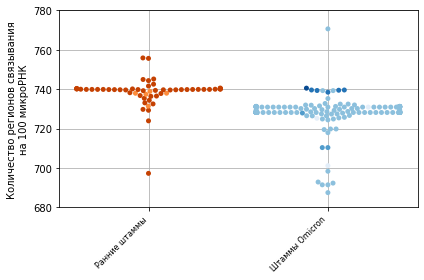

In [24]:
plot_df = count_df.loc[count_df["region"] == "RNA"].copy()
plot_df.index = plot_df["strain"]
plot_df = plot_df[["weighted count"]]

plot_df = plot_df.join(meta_df[["scorpio_call", "lineage", "group", "length"]], how="left")
plot_df.loc[plot_df["group"] == "first", "group"] = "Ранние штаммы"
plot_df.loc[plot_df["group"] == "second", "group"] = "Штаммы Omicron"
plot_df = plot_df.rename(columns={
    "scorpio_call": "Штамм"
})

plot_df["weighted count"] = plot_df["weighted count"] * 30331 / plot_df["length"]

top = mpl.colormaps['Blues_r']
bottom = mpl.colormaps['Oranges']
colors = np.vstack((
    bottom(np.linspace(0.5, 0.8, 2)),
    top(np.linspace(0.1, 0.9, 6)),
))
cmap = ListedColormap(colors, name='OrangeBlue')

ax = sns.swarmplot(
    y="weighted count",
    x="group",
    hue="Штамм",
    data=plot_df,
    palette=cmap.colors,
)

ax.set_xlabel("")
ax.set_ylabel("Количество регионов связывания\nна 100 микроРНК")

ax.set_yticks(
    [6.8, 7.0, 7.2, 7.4, 7.6, 7.8],
    [680, 700, 720, 740, 760, 780]
)

plt.xticks(
    fontsize=8,
    rotation=45,
    ha="right"
)

ax.get_legend().remove()
plt.grid()
plt.tight_layout()
plt.savefig("../../pictures/covid-weighted.png", dpi=500)

In [25]:
# seed region distribution

In [26]:
seed_df = pd.read_csv("../../results/russia_mos_LUAD/seed.csv", sep=";", index_col=0)
seed_df.index = seed_df.index.str.lstrip(">")
seed_df = seed_df.loc[STRAINS][MIMATS]

seed_df = seed_df.join(meta_df[["lineage", "length", "days", "group"]], how="left")

In [27]:
first_group = seed_df.loc[seed_df["group"] == "first"]
second_group = seed_df.loc[seed_df["group"] == "second"]

In [28]:
def extract(seeds):
    seeds = seeds.lstrip("[").rstrip("]").split(", ")
    seeds = list(map(int, [s for s in seeds if s]))
    return seeds

result_df = pd.DataFrame(columns=["group", "seed", "miRNA"])
for name, group in zip(("first", "second"), (first_group, second_group)):
    coords = []
    for mimat in MIMATS:
        expression = int(miRNA_df.loc[mimat]["CPM"] / TOTAL_EXPRESSION * 100)
        seeds = group[mimat].apply(lambda x: extract(x) * expression).to_list()
        append = []
        for s in seeds:
            append += s
        
        append_df = pd.DataFrame(columns=result_df.columns)
        append_df["seed"] = append
        append_df.loc[:, "group"] = name    
        result_df = pd.concat([result_df, append_df], ignore_index=True)
        
result_df.head()

,group,seed
0,first,9860
1,first,12449
2,first,19060
3,first,9860
4,first,12449


/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


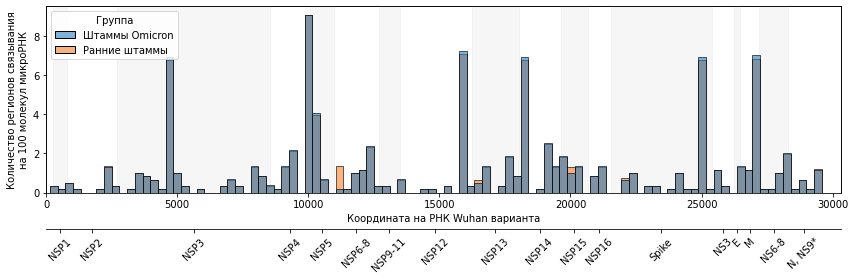

In [29]:
plot_df = result_df.copy()
plot_df.loc[plot_df["group"] == "first", "group"] = "Ранние штаммы"
plot_df.loc[plot_df["group"] == "second", "group"] = "Штаммы Omicron"
plot_df = plot_df.rename(columns={
    "group": "Группа"
})

fig, ax = plt.subplots(figsize=(12, 4))

ax.set_ylabel("Количество регионов связывания\nна 100 молекул микроРНК")
ax.set_xlabel("Координата на РНК Wuhan варианта") 
ax.set_xlim(0, 30330)

annotation = {
    "NSP1": "266-805",
    "NSP2": "806-2719",
    "NSP3": "2720-8554",
    "NSP4": "8555-10054",
    "NSP5": "10055-10972",
    # "NSP6": "10973-11842",
    # "NSP7": "11843-12091",
    # "NSP8": "12092-12685",
    "NSP6-8": "10973-12685",
    # "NSP9": "12686-13024",
    # "NSP10": "13025-13441",
    # "NSP11": "13442-13480",
    "NSP9-11": "12686-13480",
    # "NSP12": "13442-13468",
    "NSP12": "13468-16236",
    "NSP13": "16237-18039",
    "NSP14": "18040-19620",
    "NSP15": "19621-20658",
    "NSP16": "20659-21552",
    "Spike": "21563-25384",
    "NS3": "25393-26220",
    "E": "26245-26472",
    "M": "26523-27191",
    # "NS6": "27202-27387",
    # "NS7a": "27394-27759",
    # "NS7b": "27756-27887",
    # "NS8": "27894-28259",
    "NS6-8": "27202-28295",
    "N, NS9*": "28274-29533",
    # "NS9b": "28284-28577",
    # "NS9c": "28734-28955"
}

axsub = ax.twiny()
axsub.xaxis.set_ticks_position('bottom')
axsub.spines['bottom'].set_position(('outward', 36))

ticks = []
centers = []
proteins = []
for protein, region in annotation.items():
    start, end = map(int, region.split("-"))
    ticks.append(start - 1)
    ticks.append(end - 1)
    
    center = (start + end - 2) // 2
    centers.append(center)
    proteins.append(protein)

i = 0
while i < len(ticks):
    axsub.axvspan(ticks[i], ticks[i + 1], alpha=0.2, color="lightgrey")
    i += 4

top = mpl.colormaps['Blues_r']
bottom = mpl.colormaps['Oranges']
colors = np.vstack((
    top(np.linspace(0.3, 1, 1)),
    bottom(np.linspace(0.55, 1, 1))
))
cmap = ListedColormap(colors, name='OrangeBlue')
    
sns.histplot(
    x="seed",
    hue="Группа",
    hue_order=["Штаммы Omicron", "Ранние штаммы"],
    data=plot_df,
    stat="probability",
    common_norm=False,
    bins=100,
    palette=cmap.colors,
    alpha=0.6,
    ax=axsub
)

axsub.set_xlim(0, 30330)
    
axsub.set_xticks(
    centers,
    labels=proteins,
    rotation=45,
    ha="center"
)

axsub.set_xlabel("")

ax.set_yticks(
    [i / 100 for i in range(0, 9, 2)],
    labels=[i for i in range(0, 9, 2)]
)

plt.tight_layout()
plt.savefig("../../pictures/seed-distribution-test.png", dpi=500)

In [30]:
# proteins contribution

In [31]:
result_df = pd.DataFrame(columns=[
    "region", "length",
    "first weighted", "second weighted",
    "first count", "second count",
    "p-value"
])

for protein in PROTEINS:
    if protein == "RNA":
        length = 30331
    else:
        length = list(map(int, ANNOTATION[protein].split("-")))
        length = length[1] - length[0] + 1
    
    df = count_df.loc[count_df["region"] == protein]
    df.index = df["strain"]
    df = df.join(meta_df[["group", "length"]], how="left")
    df = df.drop(columns=["strain"]).reset_index()
    
    first_group = df.loc[df["group"] == "first"][[
        "strain", "weighted count", "count"
    ]].groupby("strain").sum()
    second_group = df.loc[df["group"] == "second"][[
        "strain", "weighted count", "count"
    ]].groupby("strain").sum()
    
    try:
        stat, pv = mannwhitneyu(
            first_group["weighted count"],
            second_group["weighted count"]
        )
    except:
        pv = 1
        
    append_df = pd.DataFrame(
        columns=result_df.columns.to_list(),
        data=[[
            protein,
            length,
            first_group["weighted count"].mean(),
            second_group["weighted count"].mean(),
            first_group["count"].mean(),
            second_group["count"].mean(),
            pv
        ]]
    )
    
    result_df = pd.concat([result_df, append_df], ignore_index=True)

result_df["fdr"] = np.array(result_df["p-value"]) * len(result_df) / rankdata(result_df["p-value"])
result_df.loc[result_df["fdr"] > 1, "fdr"] = 1

In [32]:
result_df.sort_values(by=["first weighted"], ascending=False)

,region,length,first weighted,second weighted,first count,second count,p-value,fdr
29,RNA,30331,7.238775,7.118004,313.894737,310.912037,3.601312e-25,1.800656e-24
3,NSP3,5835,1.063644,1.065798,50.771930,51.046296,9.787041e-04,3.670140e-03
4,NSP4,1500,0.855808,0.847009,21.912281,21.837963,2.616825e-01,4.361375e-01
17,Spike,3822,0.839587,0.835369,42.228070,42.055556,2.956951e-01,4.668870e-01
14,NSP14,1581,0.749164,0.749991,21.964912,22.000000,9.076789e-01,1.000000e+00
12,NSP12,2769,0.520763,0.521934,10.912281,10.995370,7.309553e-03,2.192866e-02
21,NS6,186,0.407872,0.413234,0.982456,0.995370,3.131012e-01,4.696518e-01
13,NSP13,1803,0.402112,0.386294,30.964912,29.791667,3.484561e-15,1.493383e-14
15,NSP15,1038,0.337228,0.311361,19.982456,18.050926,4.000911e-53,1.200273e-51
5,NSP5,918,0.327328,0.326974,14.035088,14.000000,5.929397e-03,1.976466e-02


In [33]:
print_df = result_df.drop(columns=["first count", "second count", "p-value"])
print_df["first weighted"] *= 100
print_df["second weighted"] *= 100
print_df = print_df.loc[print_df["fdr"] < 0.05].sort_values(
    by=["fdr"]
)
for column in print_df.columns:
    print(f"& {column} ", end="")
print("\\\\")
print("\\hline")

for i, row in print_df.iterrows():
    for column in print_df.columns:
        if column == "fdr":
            print(f"& {float(row[column]):.4f} ", end="")
        elif column not in ["region", "length"]:
            print(f"& {float(row[column]):.2f} ", end="")
        else:
            print(f"& {row[column]} ", end="")
    print("\\\\")
    print("\\hline")

& region & length & first weighted & second weighted & fdr \\
\hline
& NSP15 & 1038 & 33.72 & 31.14 & 0.0000 \\
\hline
& NS8 & 366 & 13.79 & 14.07 & 0.0000 \\
\hline
& NSP6 & 870 & 18.60 & 11.38 & 0.0000 \\
\hline
& N & 1260 & 19.54 & 19.60 & 0.0000 \\
\hline
& NSP2 & 1914 & 19.15 & 18.52 & 0.0000 \\
\hline
& RNA & 30331 & 723.88 & 711.80 & 0.0000 \\
\hline
& NSP13 & 1803 & 40.21 & 38.63 & 0.0000 \\
\hline
& NSP3 & 5835 & 106.36 & 106.58 & 0.0037 \\
\hline
& NSP5 & 918 & 32.73 & 32.70 & 0.0198 \\
\hline
& NSP12 & 2769 & 52.08 & 52.19 & 0.0219 \\
\hline


In [34]:
print_df = result_df.drop(columns=["first count", "second count", "p-value"])
print_df["first weighted"] *= 100
print_df["second weighted"] *= 100
print_df = print_df.loc[print_df["fdr"] < 0.05].sort_values(
    by=["fdr"]
)
print(print_df)

   region length  first weighted  second weighted           fdr
15  NSP15   1038       33.722776        31.136055  1.200273e-51
24    NS8    366       13.791845        14.071688  1.727903e-50
6    NSP6    870       18.595850        11.381682  6.121203e-46
25      N   1260       19.538328        19.598403  3.624348e-43
2    NSP2   1914       19.146248        18.517252  2.015643e-35
29    RNA  30331      723.877464       711.800443  1.800656e-24
13  NSP13   1803       40.211226        38.629386  1.493383e-14
3    NSP3   5835      106.364385       106.579838  3.670140e-03
5    NSP5    918       32.732752        32.697407  1.976466e-02
12  NSP12   2769       52.076326        52.193441  2.192866e-02


In [35]:
result_df.loc[result_df["region"] != "RNA"][["first weighted", "second weighted"]].sum()

first weighted     7.378267
second weighted    7.258431
dtype: float64

In [36]:
result_df.loc[result_df["region"] == "RNA"][["first count", "second count"]].sum()

first count     313.894737
second count    310.912037
dtype: float64

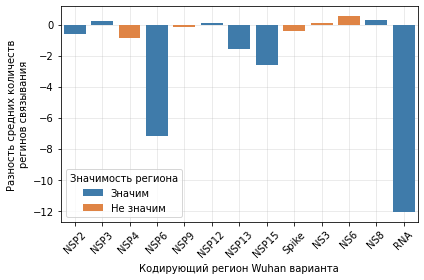

In [37]:
plot_df = result_df.copy()

plot_df["difference"] = (plot_df["second weighted"] - plot_df["first weighted"]) * 100
plot_df["fdr"] = np.array(plot_df["p-value"]) * len(plot_df) / rankdata(plot_df["p-value"])

plot_df["Значимость региона"] = "Не значим"
plot_df.loc[plot_df["fdr"] < 0.05, "Значимость региона"] = "Значим"

top = mpl.colormaps['Blues_r']
bottom = mpl.colormaps['Oranges']
colors = np.vstack((
    top(np.linspace(0.3, 1, 1)),
    bottom(np.linspace(0.55, 1, 1))
))
cmap = ListedColormap(colors, name='OrangeBlue')

ax = sns.barplot(
    x="region",
    y="difference",
    hue="Значимость региона",
    hue_order=["Значим", "Не значим"],
    data=plot_df.loc[np.abs(plot_df["difference"]) > 0.1],
    palette=cmap.colors,
    dodge=False
)

plt.xlabel("Кодирующий регион Wuhan варианта")
plt.ylabel("Разность средних количеств\nрегинов связывания")
ax.set_axisbelow(True)
plt.grid(alpha=0.3)
plt.xticks(
    rotation=45,
    ha="center"
)
plt.tight_layout()
plt.savefig("../../pictures/mRNA-contribution.png", dpi=500)